## Preprocessing


All csv files containing run statistics are read and a single dataframe is created with the concatenated csvs by adding a 'lambda' column with the arrival rate values. Three other columns are extracted from the 'statistic' column: 'node' containing the reference node of the statistic or system if it is global, 'metric' indicating the measured metric and finally 'stat' specifying whether the measured value is mean, minimum, maximum or standard deviation.

Finally, a list of dataframes is created one for each metric and node taking only the mean as the statistic.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy

output_path = os.path.join(".", "output")
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Function to remove outliers based on Z-score
def remove_outliers_zscore(df, column, threshold=3):
    """
    Removes outliers from the DataFrame based on the Z-score method.
    
    Args:
    - df (pd.DataFrame): Input DataFrame.
    - column (str): Column name to calculate Z-score.
    - threshold (float): Z-score threshold for identifying outliers.

    Returns:
    - pd.DataFrame: DataFrame with outliers removed.
    """
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    return df[z_scores <= threshold]

def preprocessing(path):
    filenames = os.listdir(path)
    stats_df_list = []
    for i in filenames:
        lambda_val = i.split('=')[1].split('_')[0]
        stats_path = os.path.join(path, i)
        stats_df = pd.read_csv(stats_path)
        stats_df['lambda'] = lambda_val
        stats_df_list.append(stats_df)
    stats_df = pd.concat(stats_df_list)

    stats_df['node'] = stats_df['statistic'].apply(lambda x: x.split('-')[0])
    stats_df['metric'] = stats_df['statistic'].apply(lambda x: x.split('-')[1])
    stats_df['stat'] = stats_df['statistic'].apply(lambda x: x.split('-')[2])
    stats_df.drop(columns=['statistic'], inplace=True)

    # List of one DataFrame for each metric selecting only the average as statistic
    metrics = stats_df['metric'].unique()
    metrics_avg_df_list = []
    for i in metrics:
        metrics_avg_df = stats_df[stats_df['metric'] == i]
        metrics_avg_df = metrics_avg_df[metrics_avg_df['stat'] == 'avg']
        
        # Remove outliers for the 'value' column (or other numerical columns)
        if 'value' in metrics_avg_df.columns:
            metrics_avg_df = remove_outliers_zscore(metrics_avg_df, 'value')
        
        metrics_avg_df_list.append(metrics_avg_df)

    metrics_nodes_avg_df_list = []
    for i in metrics_avg_df_list:
        nodes = i['node'].unique()
        node_avg_df_list = []
        for j in nodes:
            node_avg_df = i[i['node'] == j]
            node_avg_df_list.append(node_avg_df)
        metrics_nodes_avg_df_list.append(node_avg_df_list)
    return metrics_nodes_avg_df_list


## Boxplot funcion
Boxplots of the average of population number, throughput and response time with arrival rate in a range 0.5, 1.2 job/sec

In [9]:
def boxplot(metrics_nodes_avg_df_list):    
    for metric in metrics_nodes_avg_df_list:
        figure, axis = plt.subplots(2, 2, figsize=(15, 10))
        for i, boxplot_df in enumerate(metric):
            boxplot_df['value'].astype(float)
            boxplot_df['lambda'].astype(float)
            boxplot_df = boxplot_df.sort_values(by='lambda')

            curr_metric = boxplot_df['metric'].unique()[0]
            curr_node = boxplot_df['node'].unique()[0]
            x = i // 2
            y = i % 2
            boxplot_df.boxplot(column='value', by='lambda', ax = axis[x,y], showfliers=False)
            plt.suptitle('')
            axis[x,y].set_title(f'Boxplot of {curr_metric} of the {curr_node} node')

        plt.tight_layout()
        plt.show()

## Confidence interval calculation
Confidence intervals are calculated on the batches of runs made as the lambda parameter changes.

The following formula is used to calculate the interval:

$
CI = \bar{x} \pm z \cdot \frac{\sigma}{\sqrt{n}}
$

Where:
- $\bar{x}$ is the sample mean.
- $z$ is the critical value of the standard normal distribution corresponding to the chosen confidence level (e.g., 1.96 for 95%).
- $\sigma$ is the population standard deviation.
- $n$ is the sample size.

In [10]:
def confidence_interval(metrics_nodes_avg_df_list, critical_value):
    cv_df = []
    for metric in metrics_nodes_avg_df_list:
        metric_list = []
        for node_df in metric:
            curr_metric = node_df['metric'].unique()[0]
            curr_node = node_df['node'].unique()[0]
            
            df = node_df.groupby(["lambda"])['value'].describe()[["count", "mean", "std"]].reset_index()
            df["lower_ci"] = df["mean"] - critical_value*(df["std"]/np.sqrt(df["count"]))
            df["upper_ci"] = df["mean"] + critical_value*(df["std"]/np.sqrt(df["count"]))

            df.to_csv(f"output\conf_int_{curr_node}_{curr_metric}.csv", index=False)
            df['metric'] = curr_metric
            df['node'] = curr_node
            metric_list.append(df)
        cv_df.append(metric_list)
    return cv_df

In [11]:
def plot_confidence_interval(cv_df):
    for metric in cv_df:
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))
        for i, df in enumerate(metric):
            x = i // 2
            y = i % 2
            # error bar plot with mean point
            up = df['upper_ci'] - df['mean']
            low = df['mean'] - df['lower_ci']
            axs[x, y].errorbar(df['lambda'], df['mean'], yerr=[low, up], fmt='o', capsize=5, label='Confidence interval 95%')

            # lineplot of the mean points
            axs[x, y].plot(df['lambda'], df['mean'], linestyle='-', marker='o', color='b', label='Avg')

            axs[x, y].set_xlabel('Lambda')
            axs[x, y].set_ylabel(f"Avg {df['metric'].unique()[0]} in {df['node'].unique()[0]}")
            axs[x, y].set_title(f"Confidence interval for {df['node'].unique()[0]} average {df['metric'].unique()[0]}")
            axs[x, y].legend()
        plt.tight_layout()
        plt.show()


## Objective 1

Implementation of a model to execute the web app workflow to measure response time (R), population number (N) and throughput (X) quantities

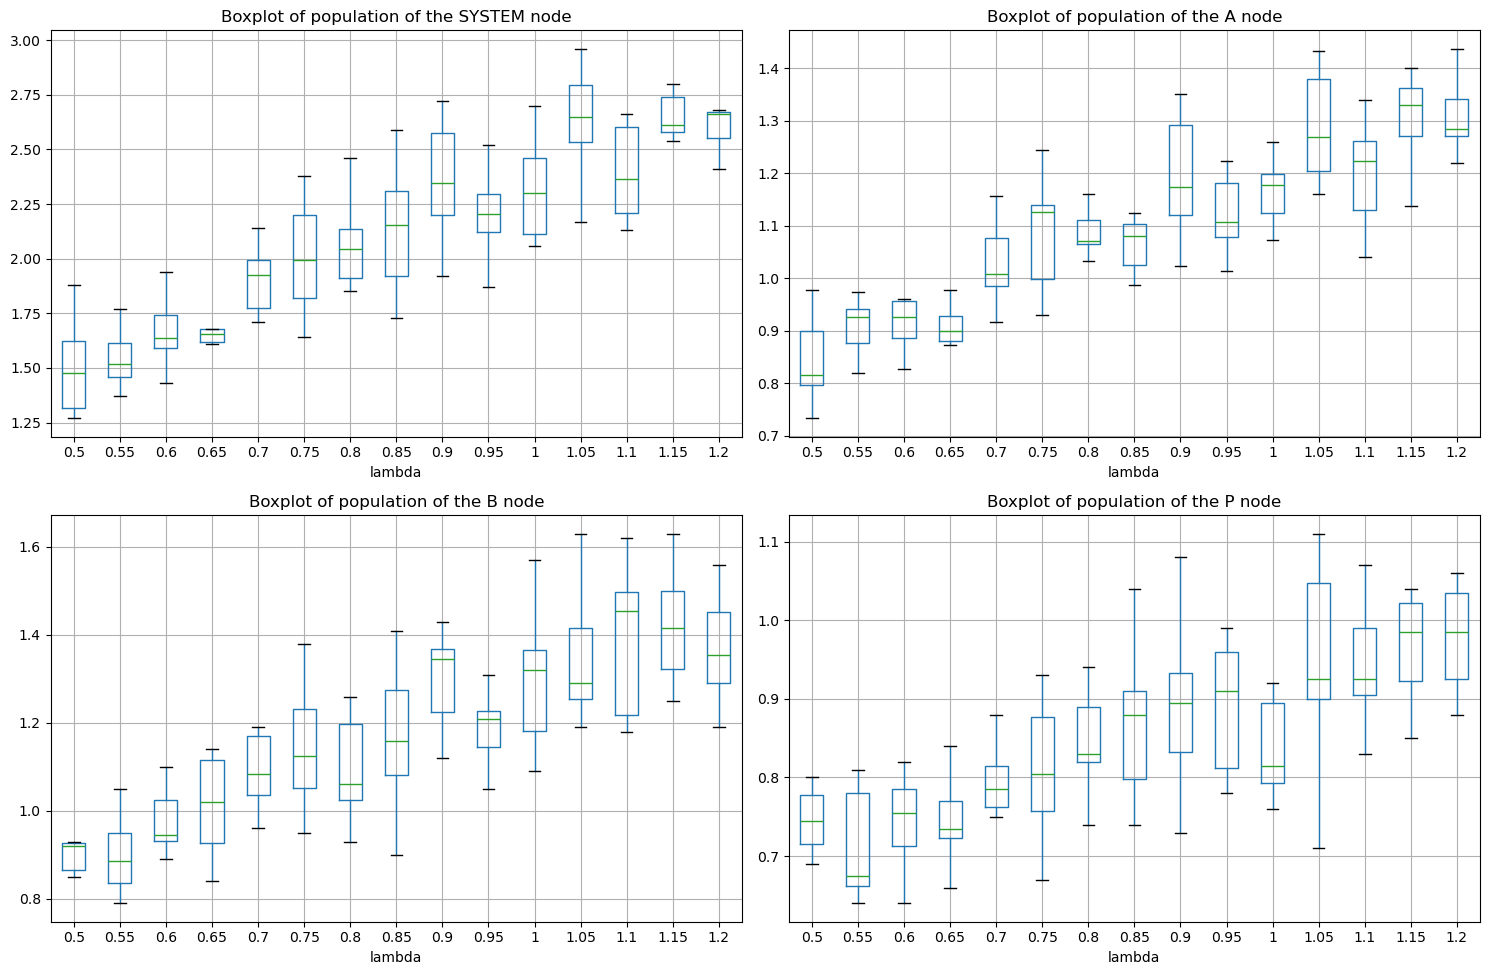

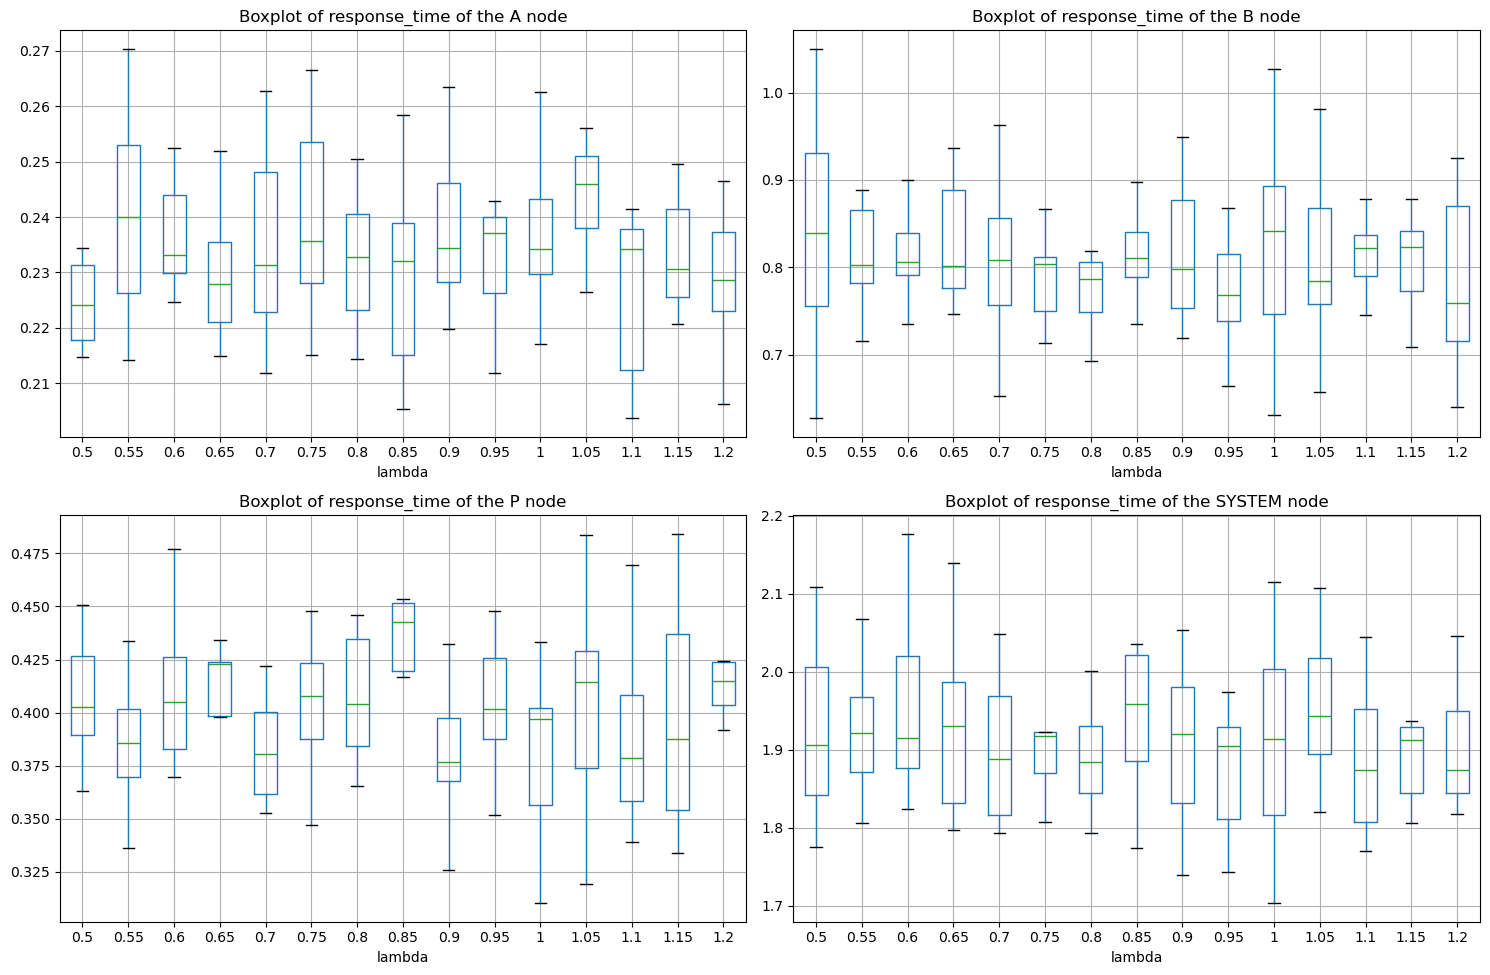

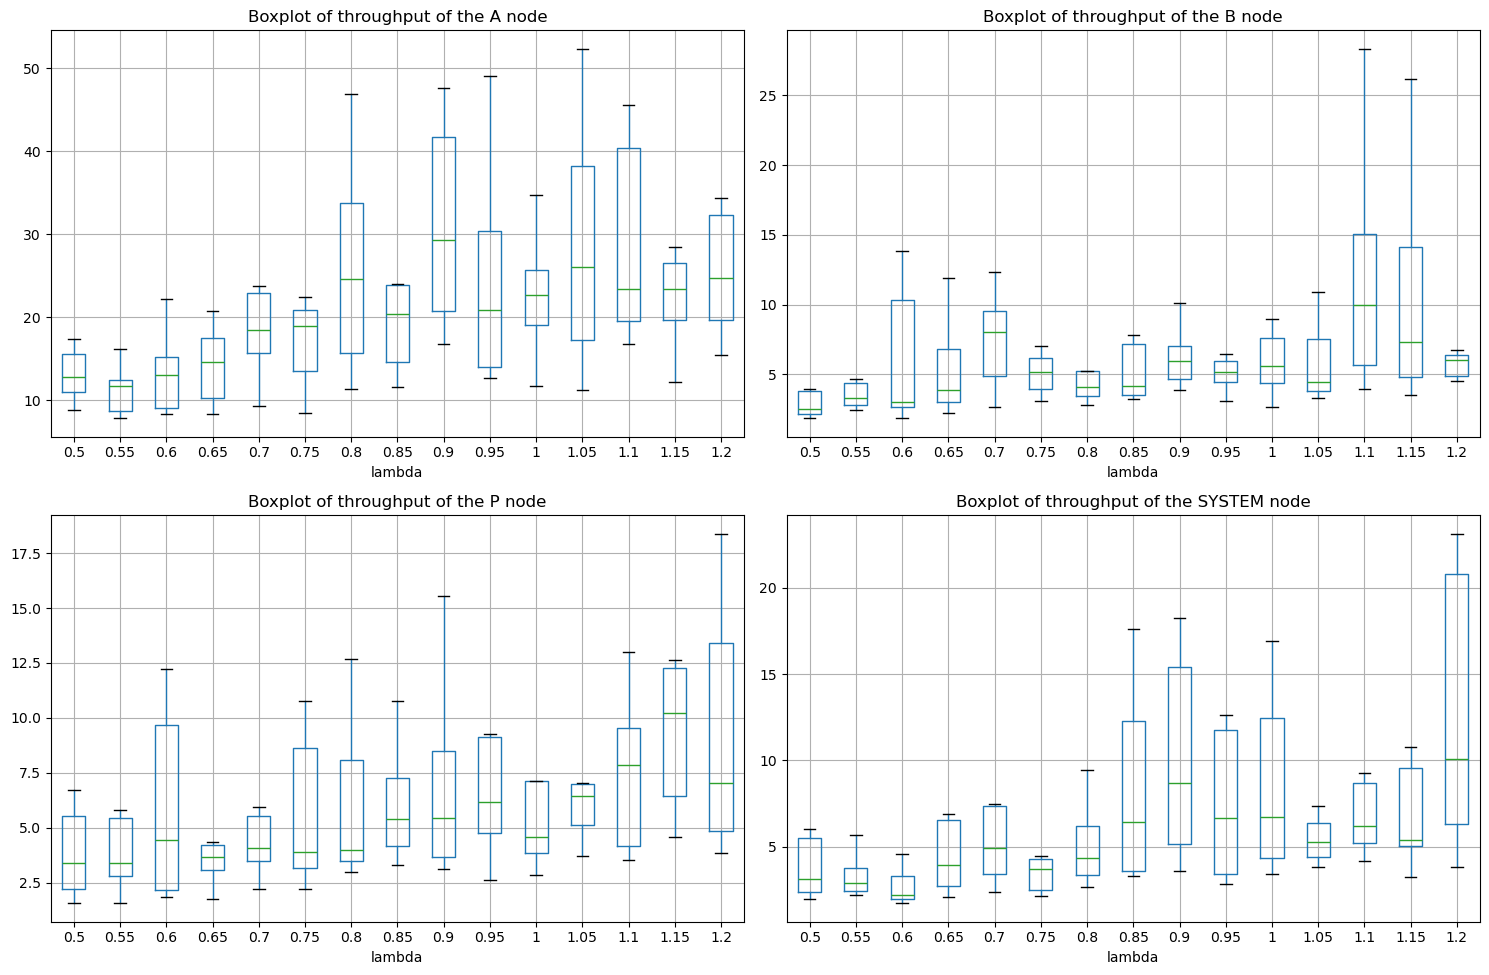

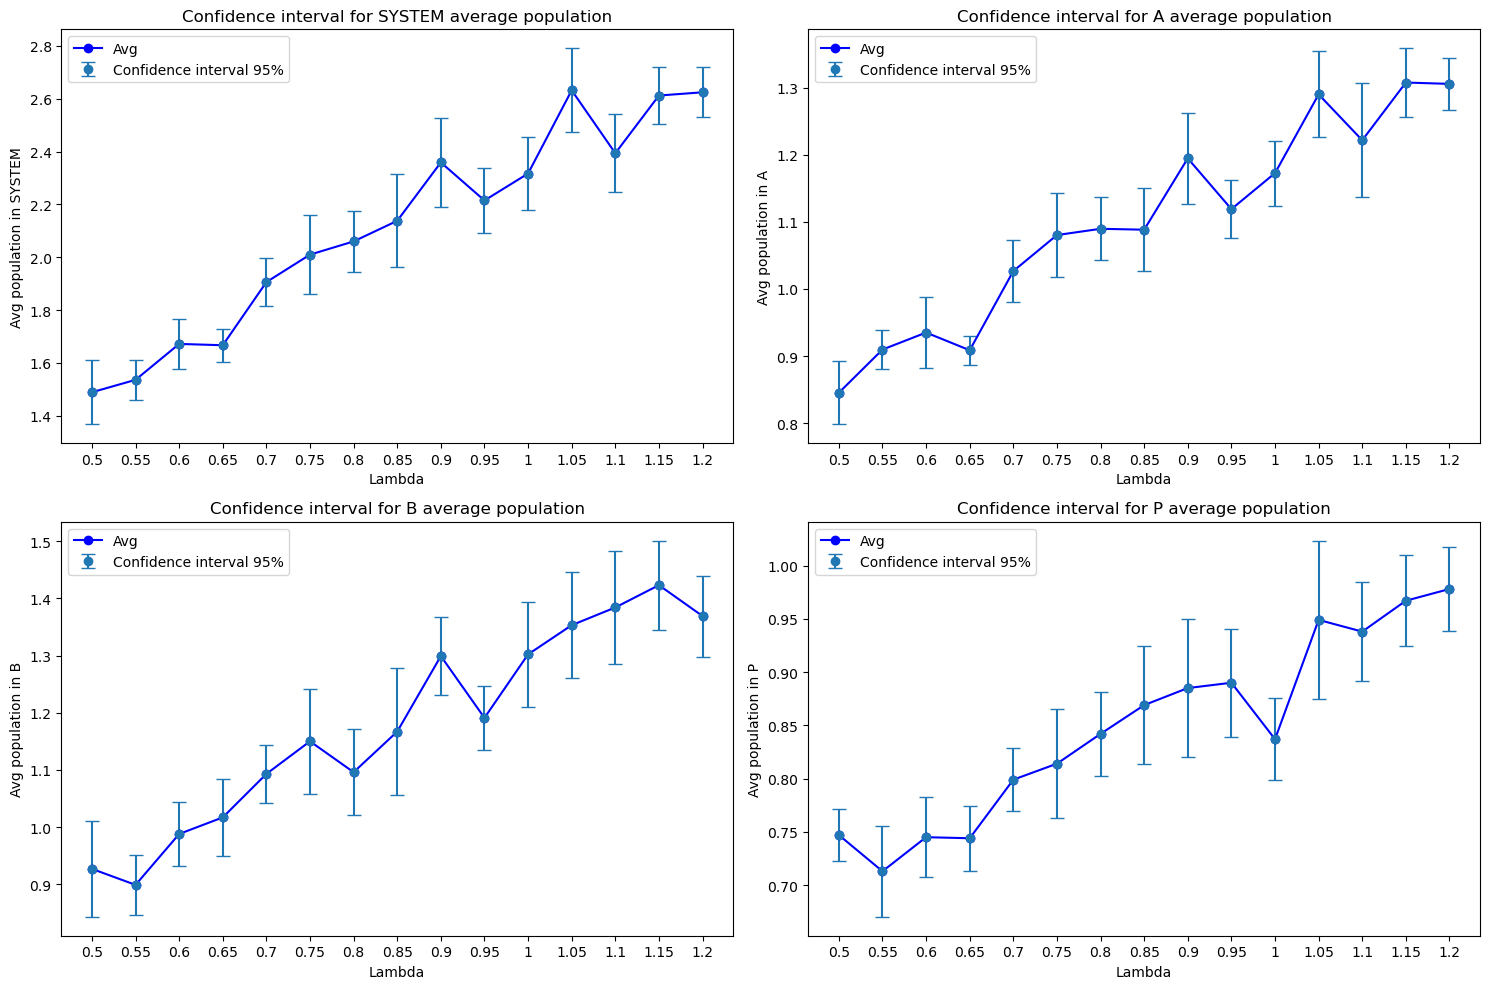

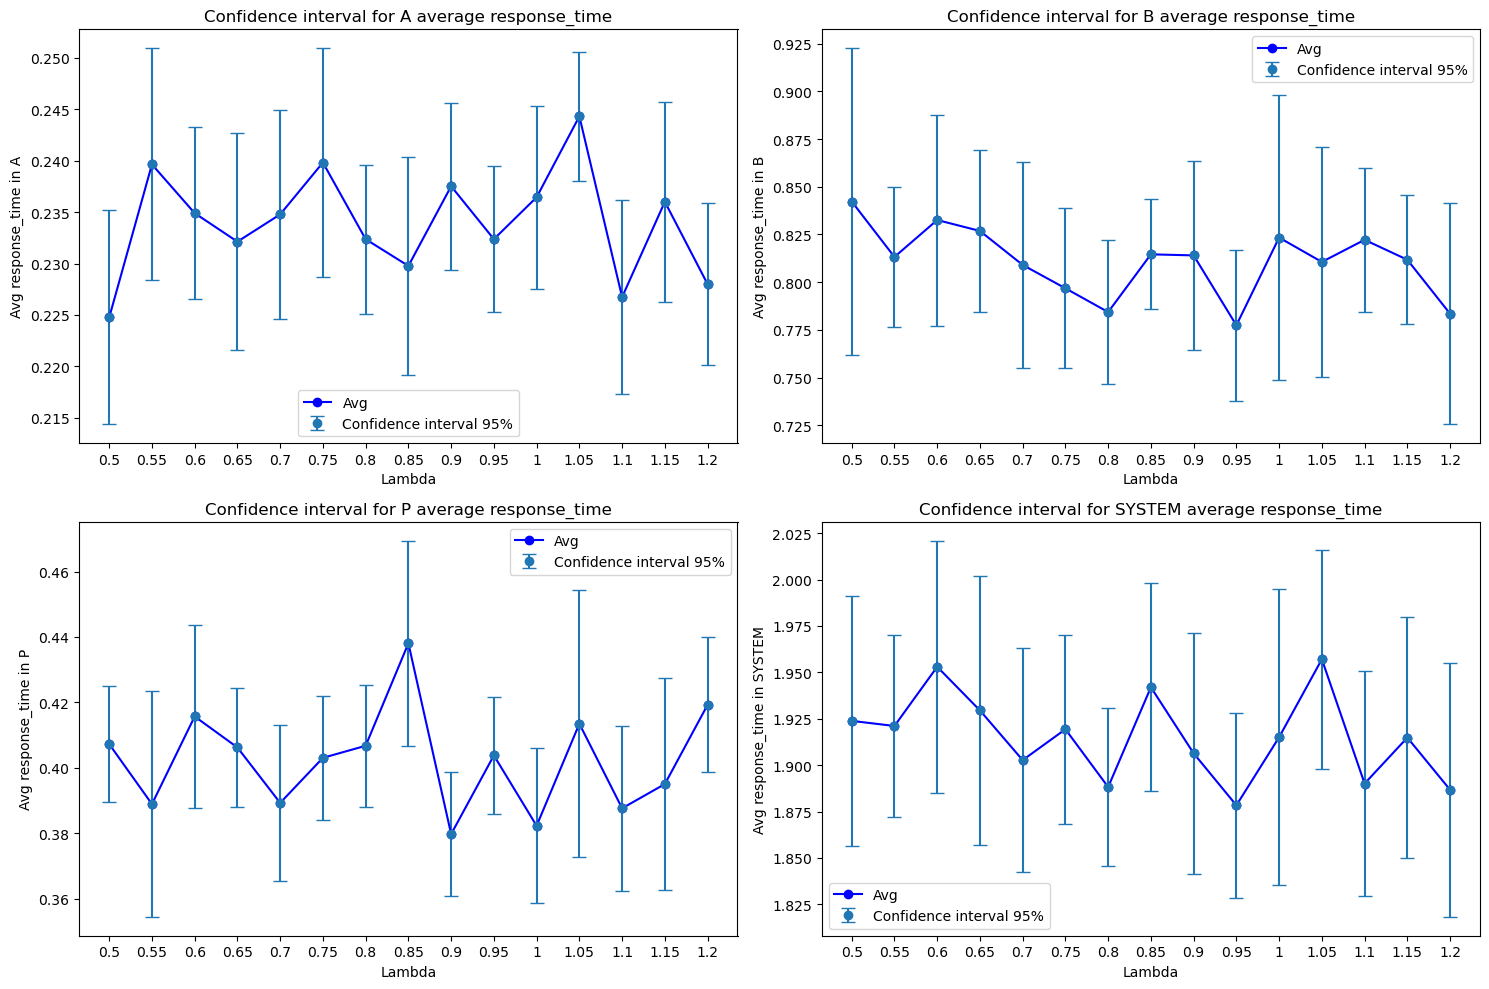

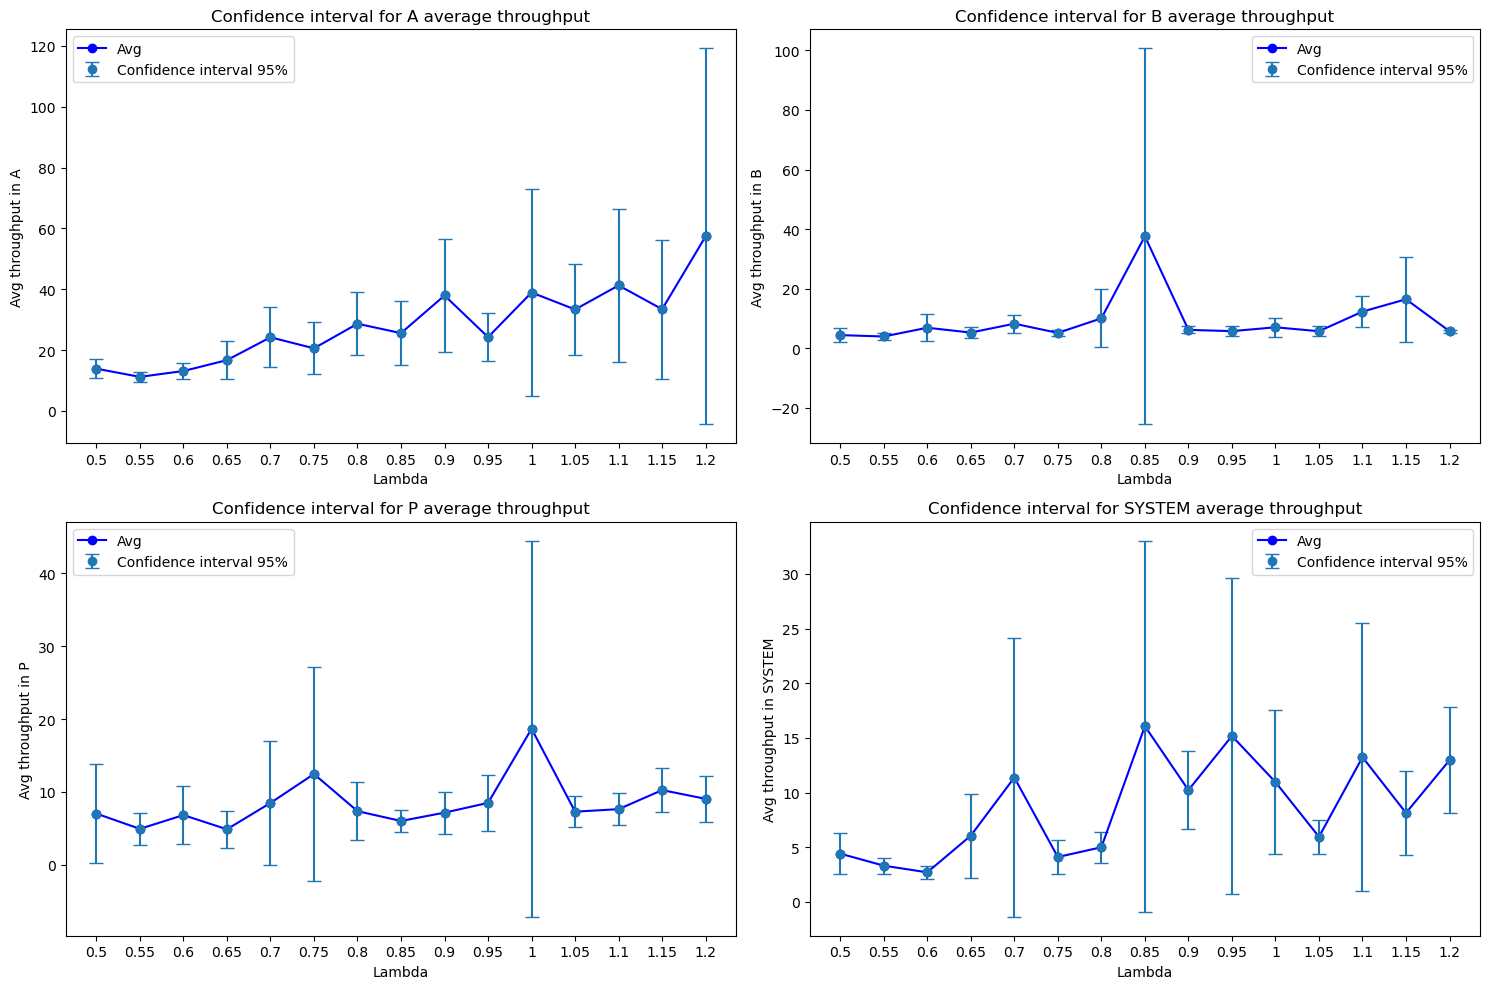

In [12]:
path = os.path.join("..", "..", "src", "caballo", "domestico", "wwsimulator", "statistics", "objective_1")
critical_value = scipy.stats.norm.ppf(1-.05/2)

metrics_nodes_avg_df_list = preprocessing(path)
boxplot(metrics_nodes_avg_df_list)
cv_df = confidence_interval(metrics_nodes_avg_df_list, critical_value)
plot_confidence_interval(cv_df)

## Objective 2

The model adds the functionality of two-factor authentication, observe the three metrics variation.

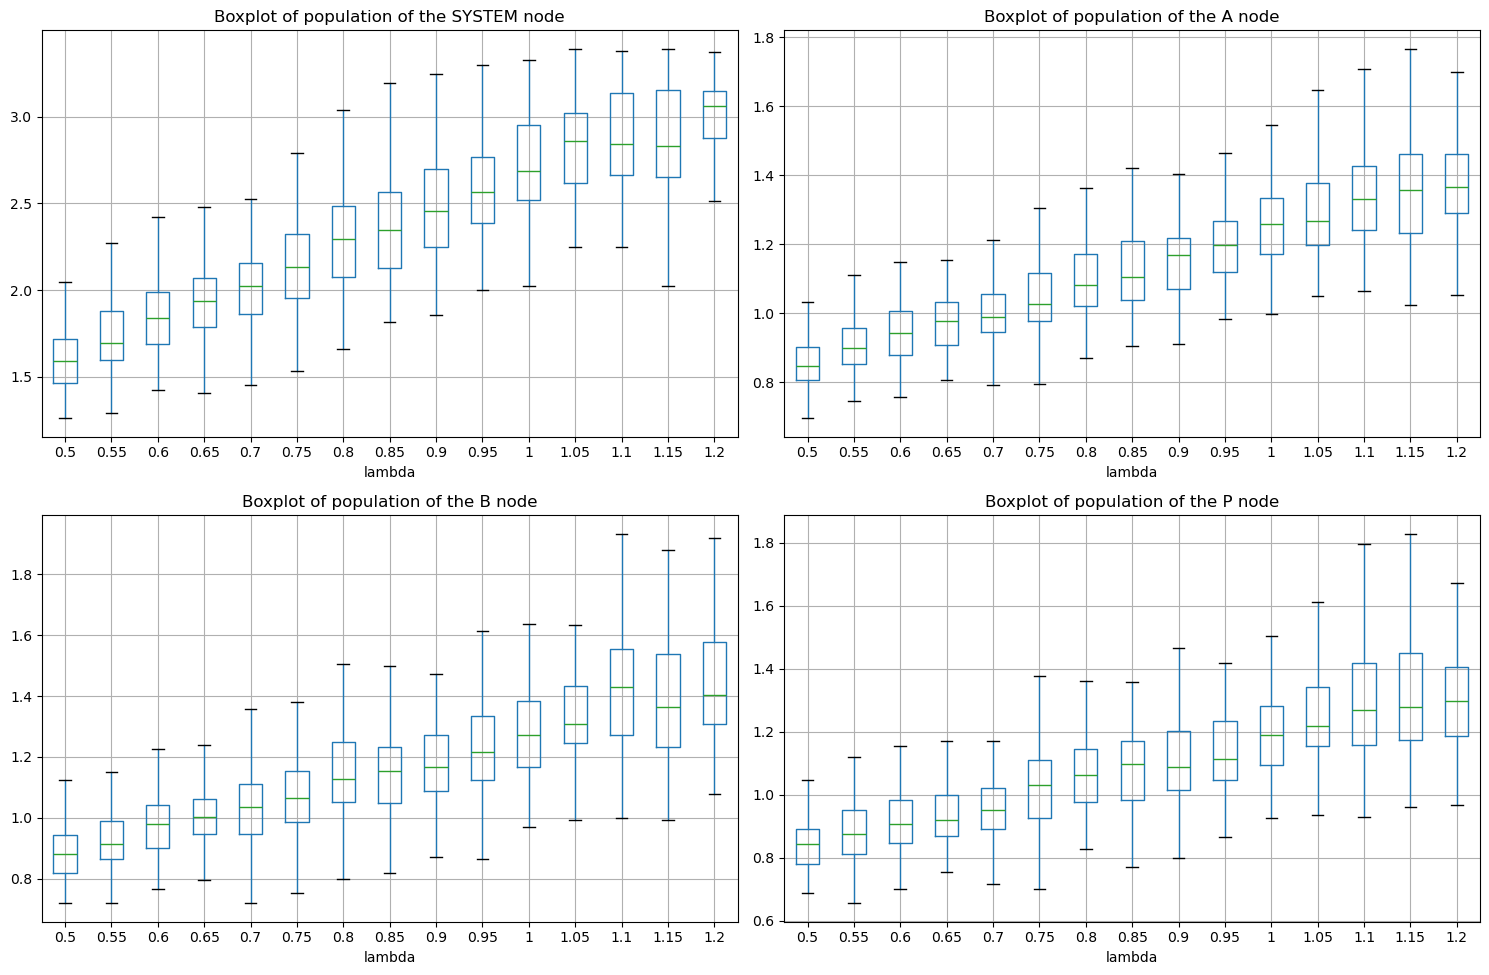

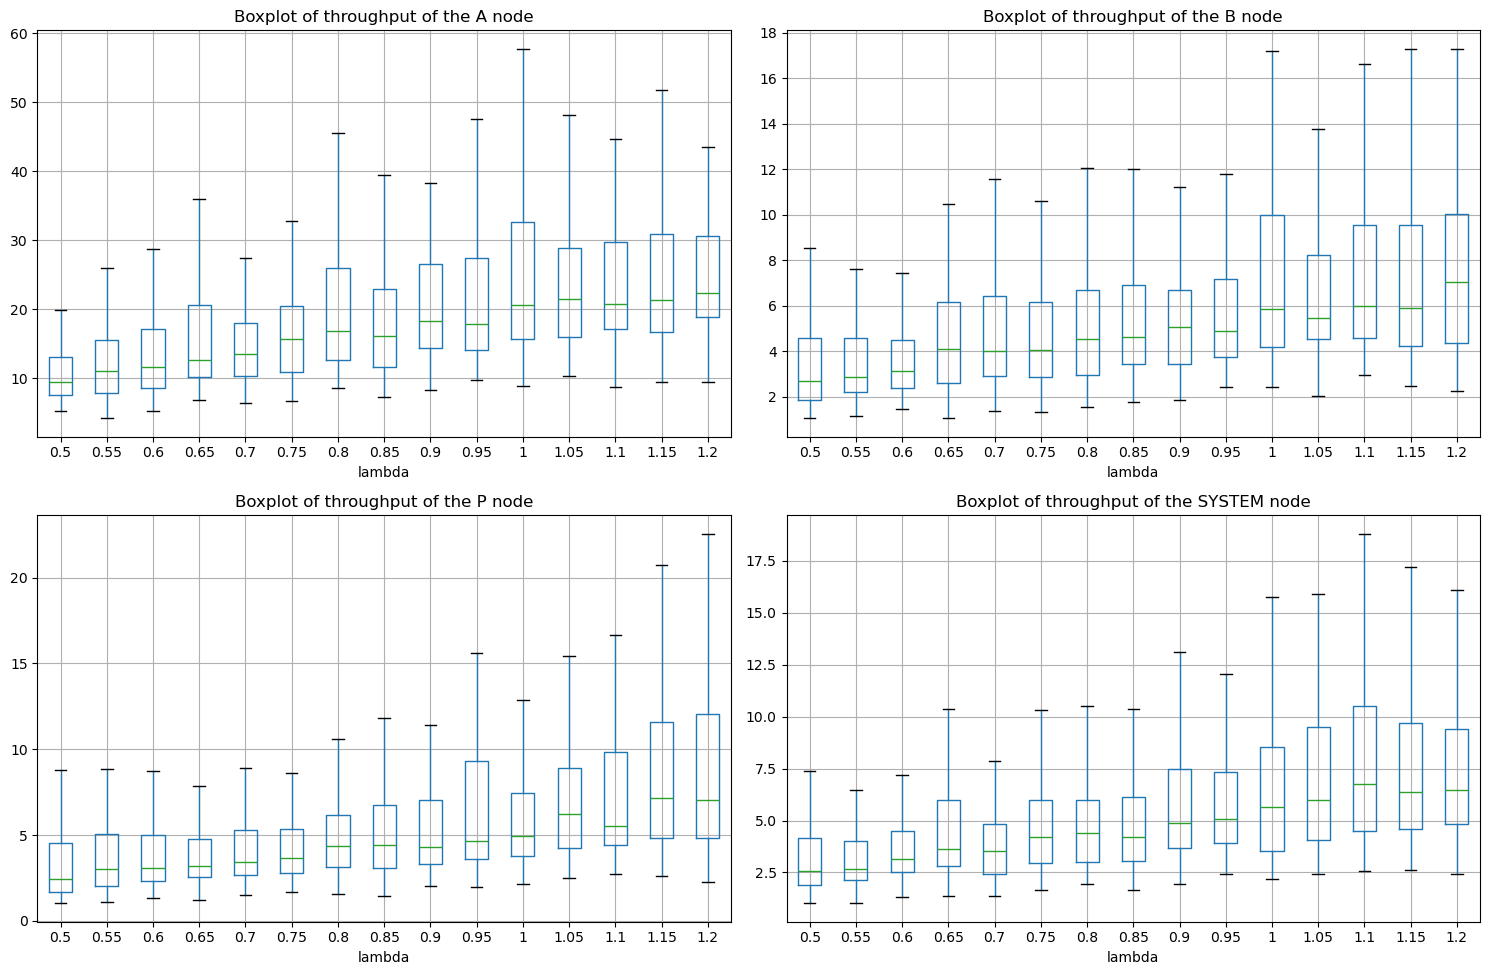

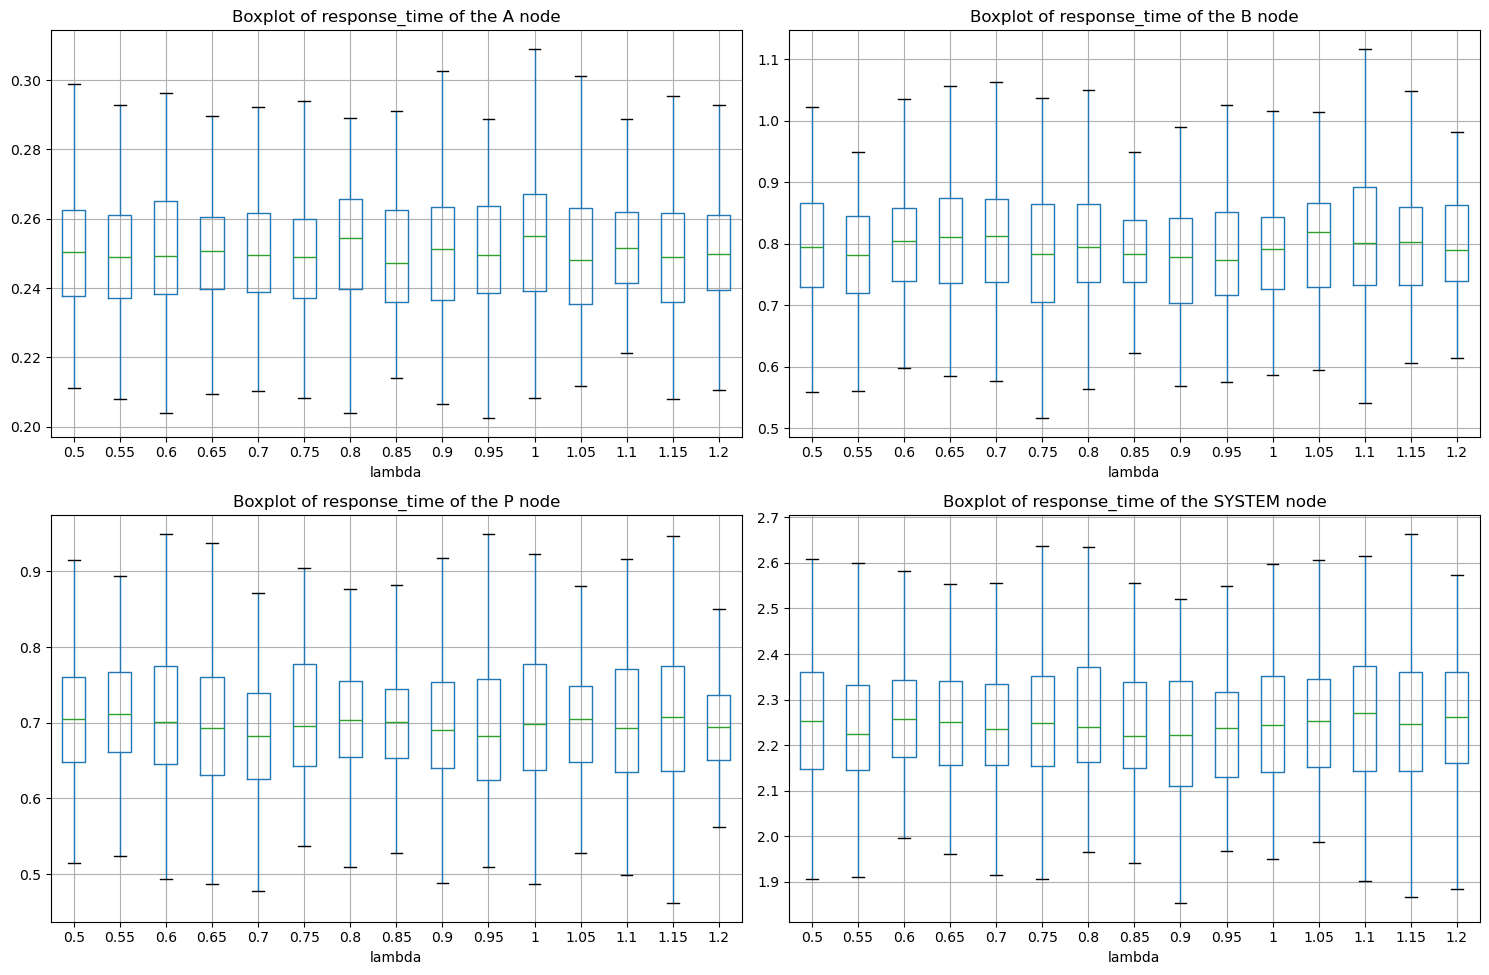

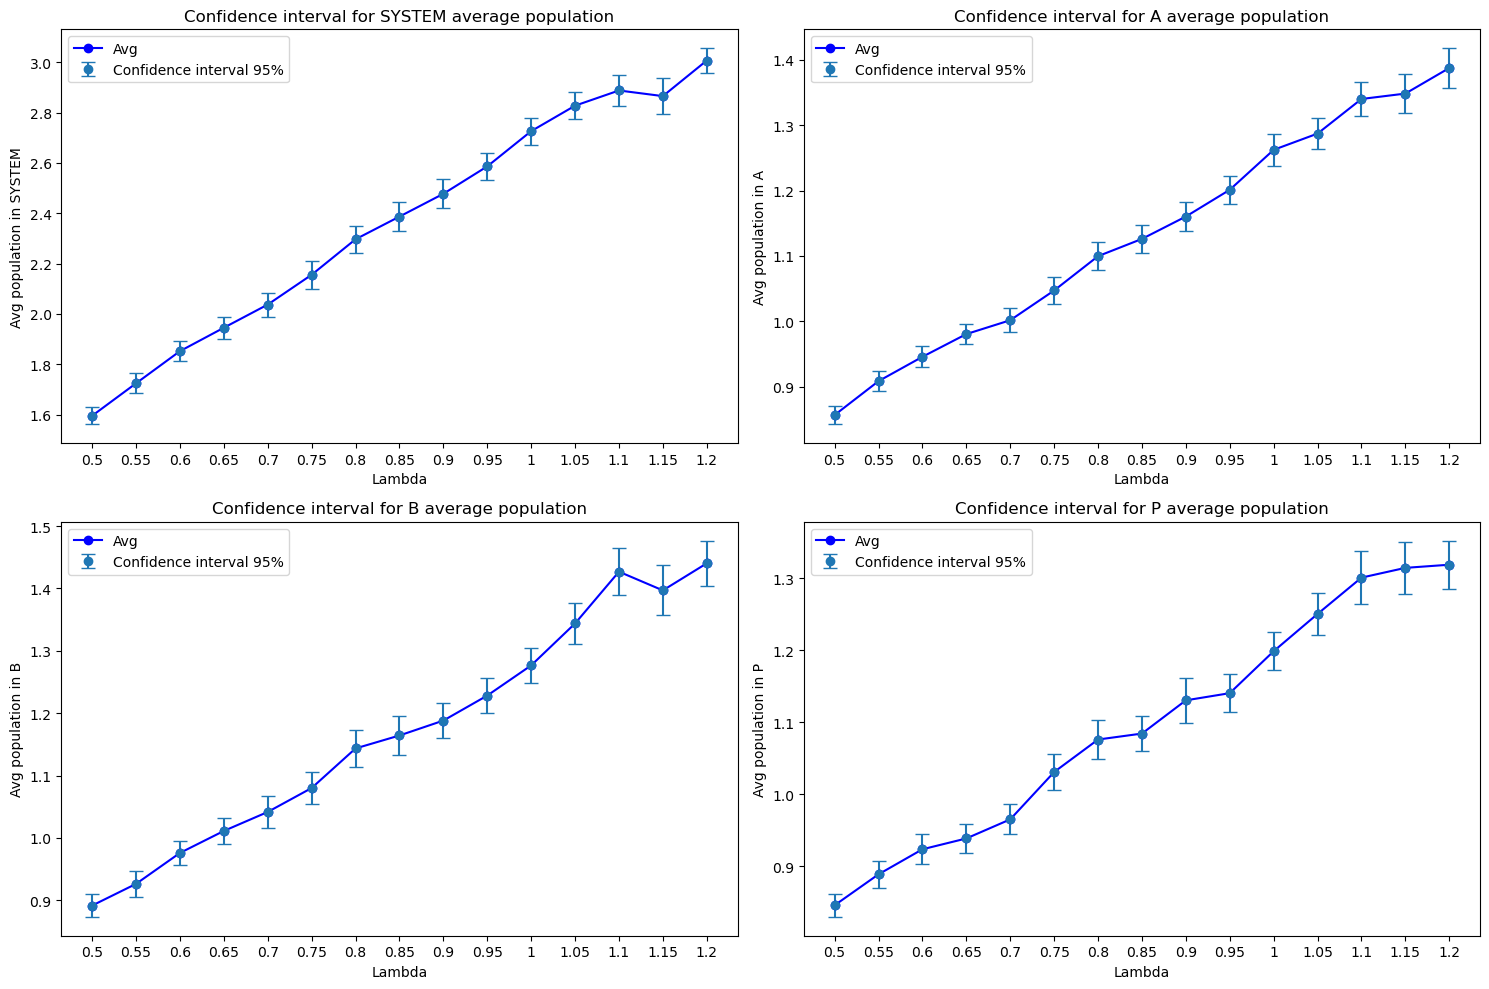

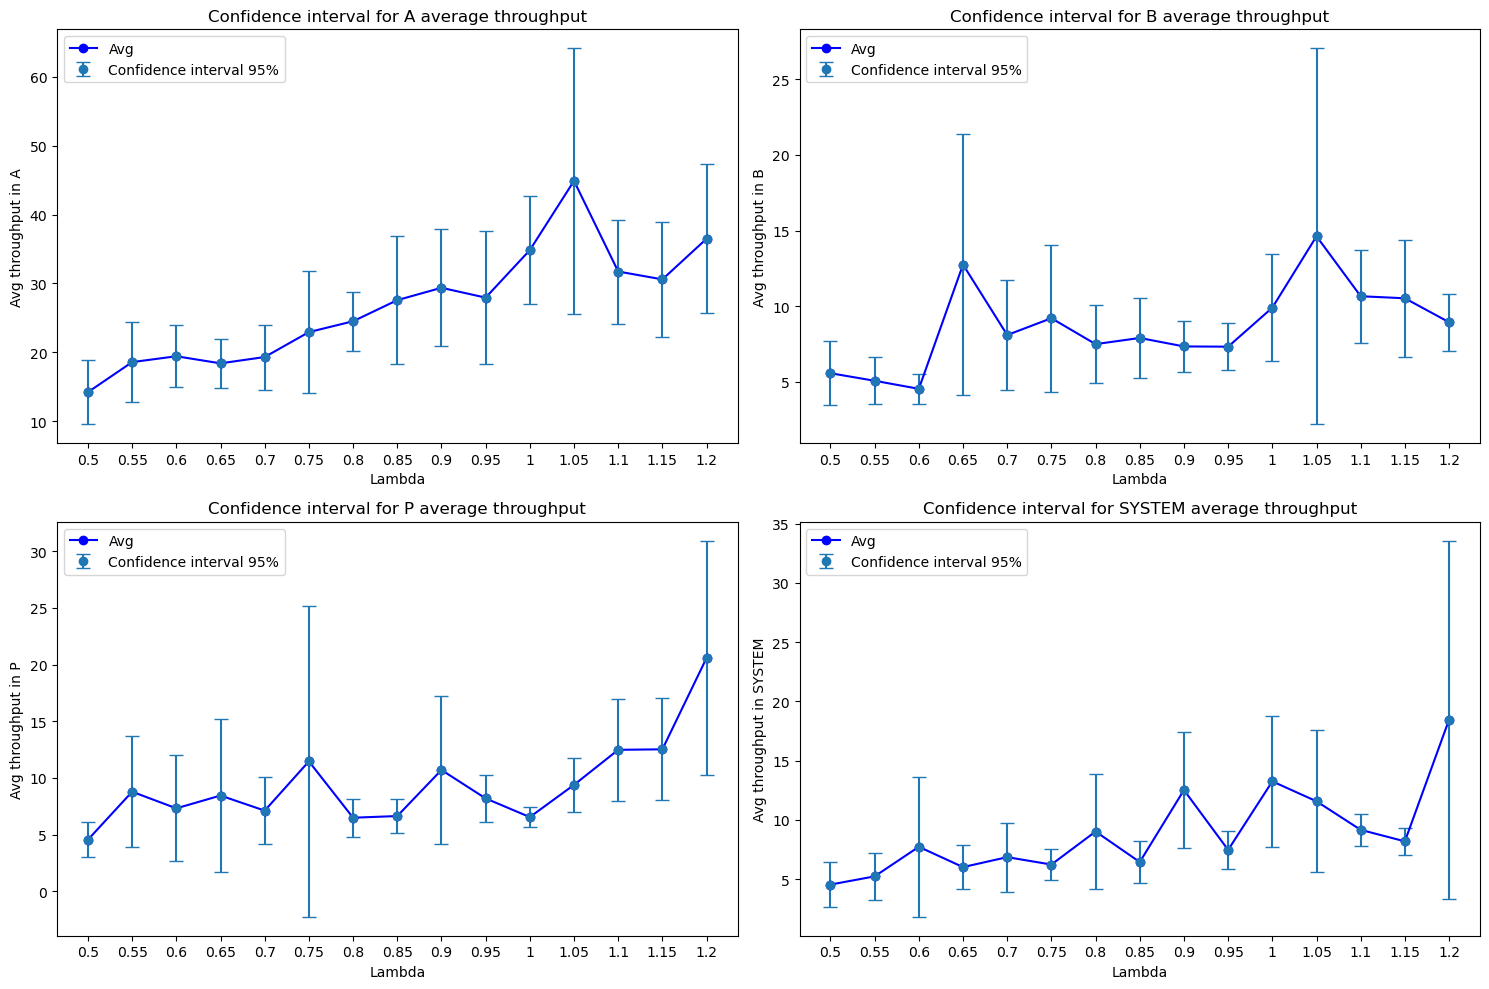

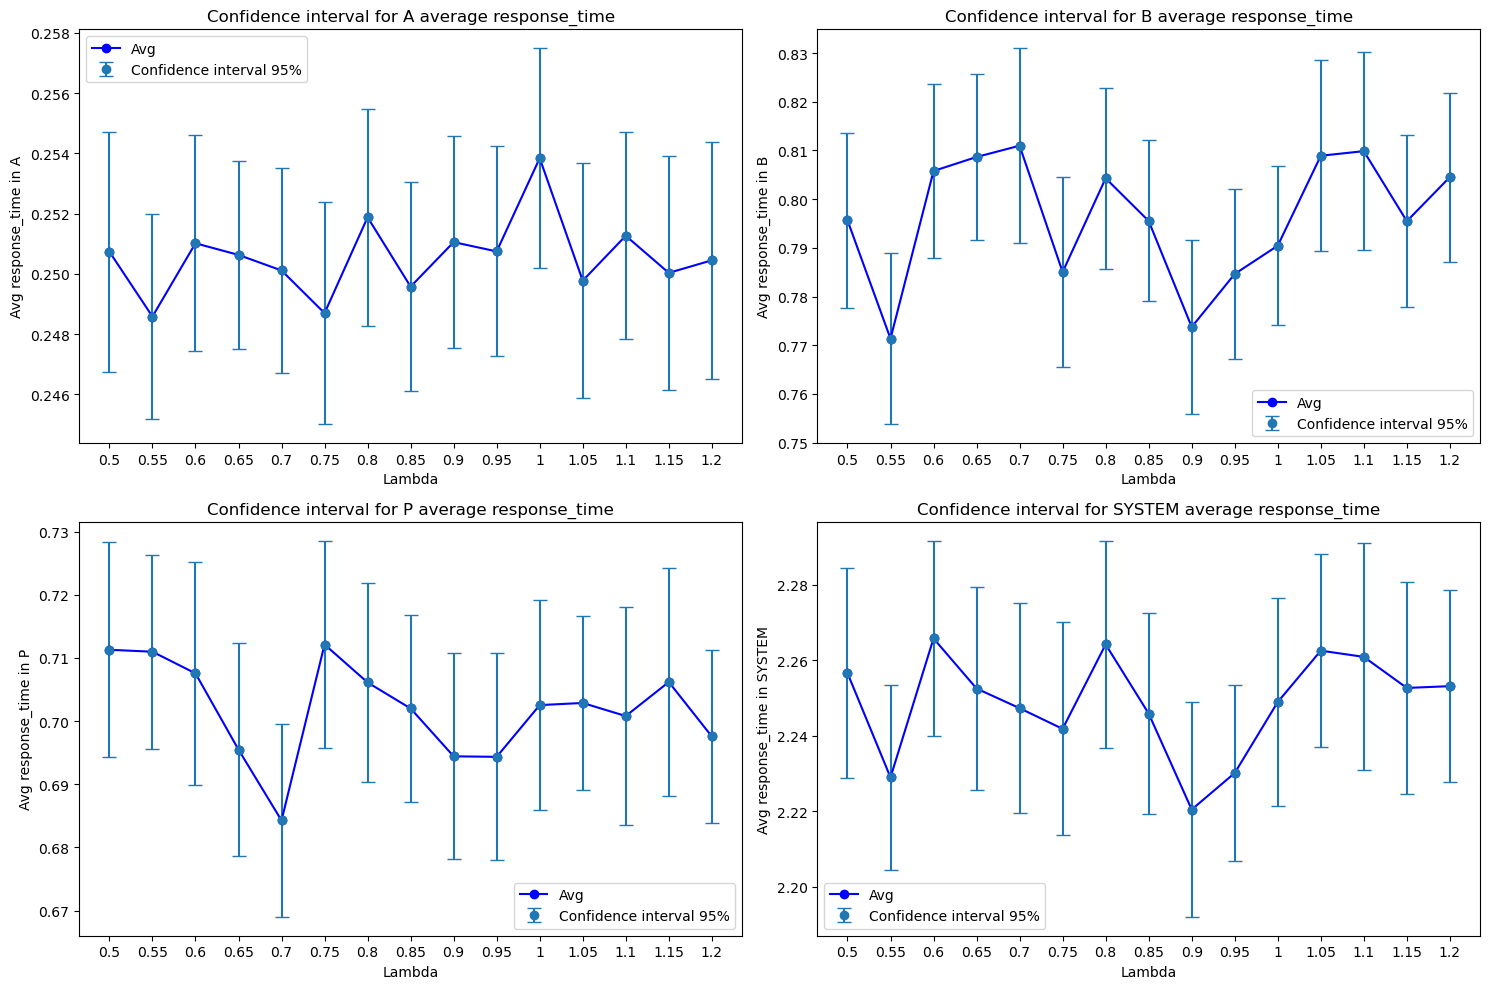

In [13]:
path = os.path.join("..", "..", "src", "caballo", "domestico", "wwsimulator", "statistics", "objective_2")
critical_value = scipy.stats.norm.ppf(1-.05/2)

metrics_nodes_avg_df_list = preprocessing(path)
boxplot(metrics_nodes_avg_df_list)
cv_df = confidence_interval(metrics_nodes_avg_df_list, critical_value)
plot_confidence_interval(cv_df)

## Objective 3

Measure the metrics with an increased workload from 4200 req/h to 5000 req/h

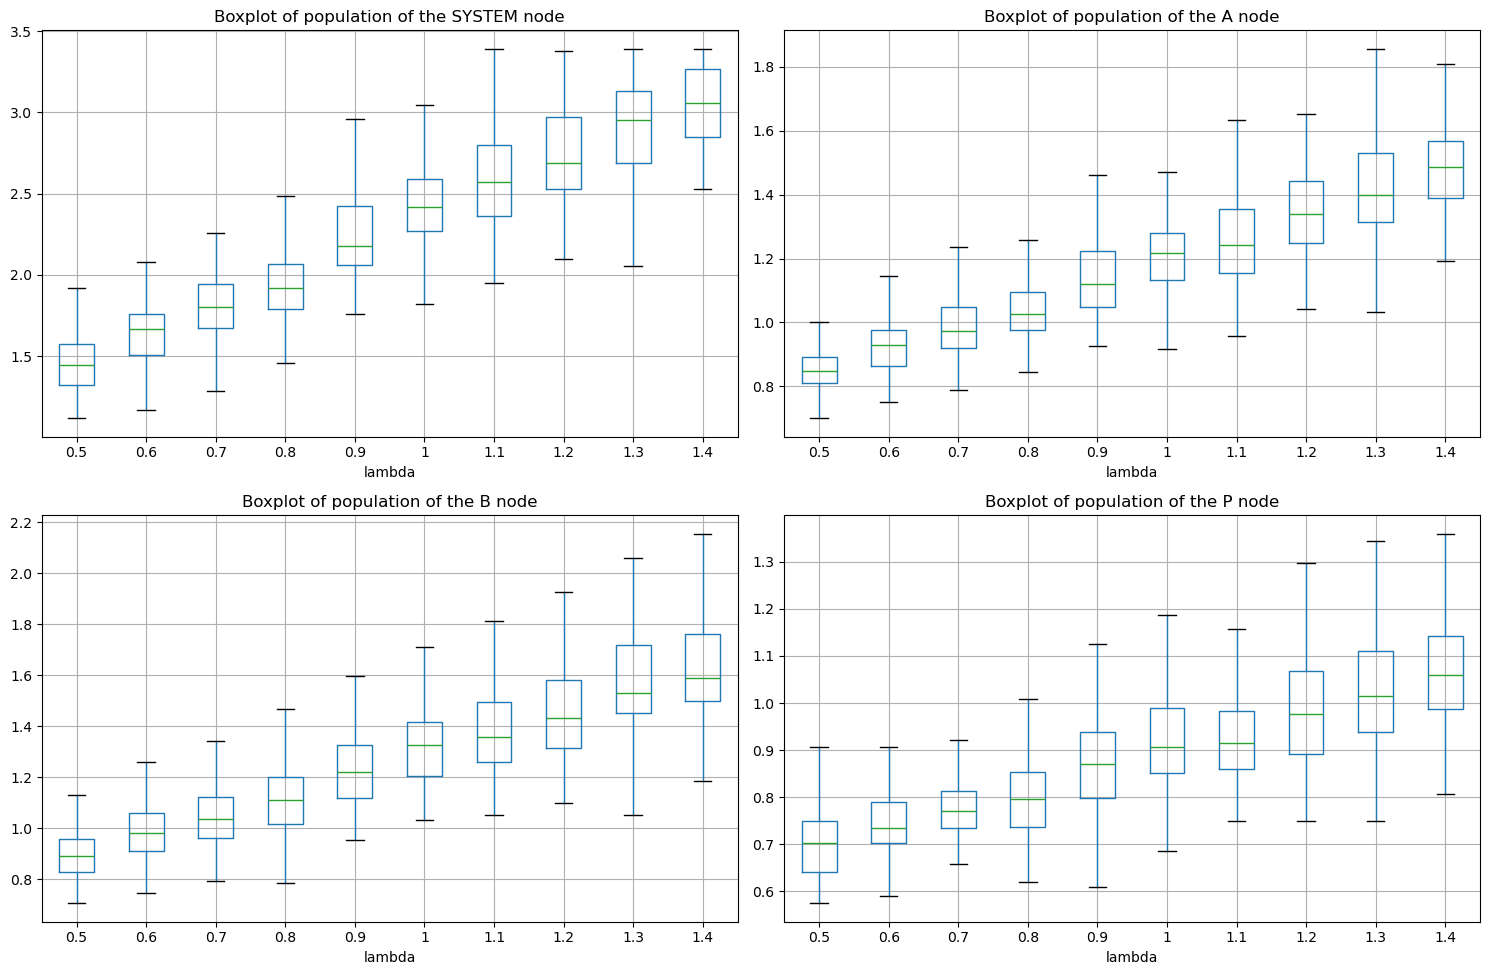

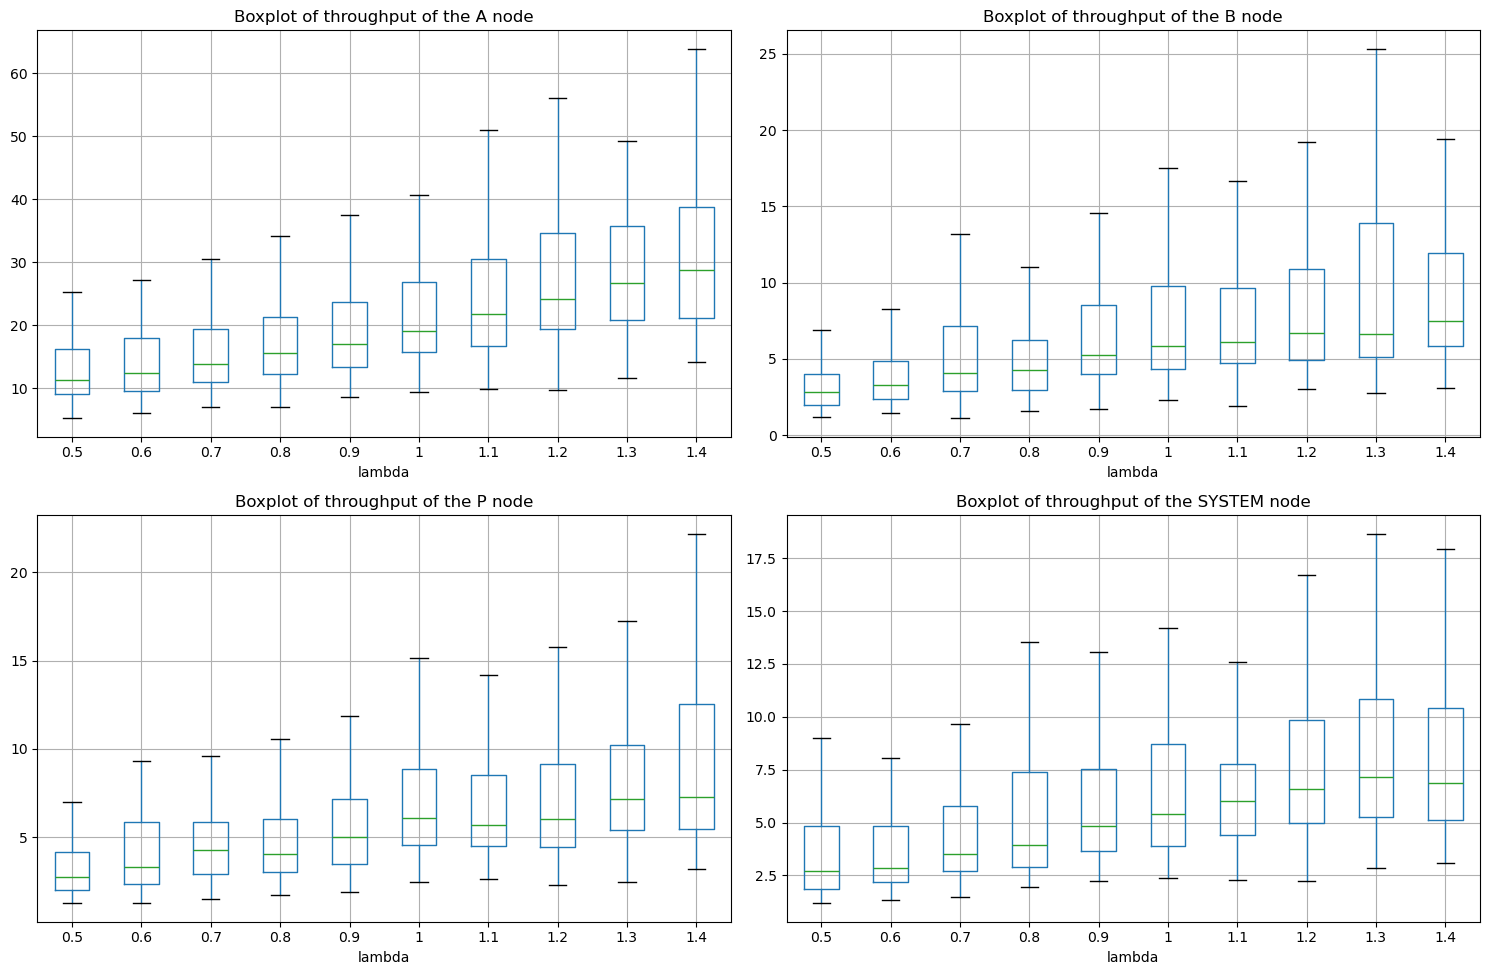

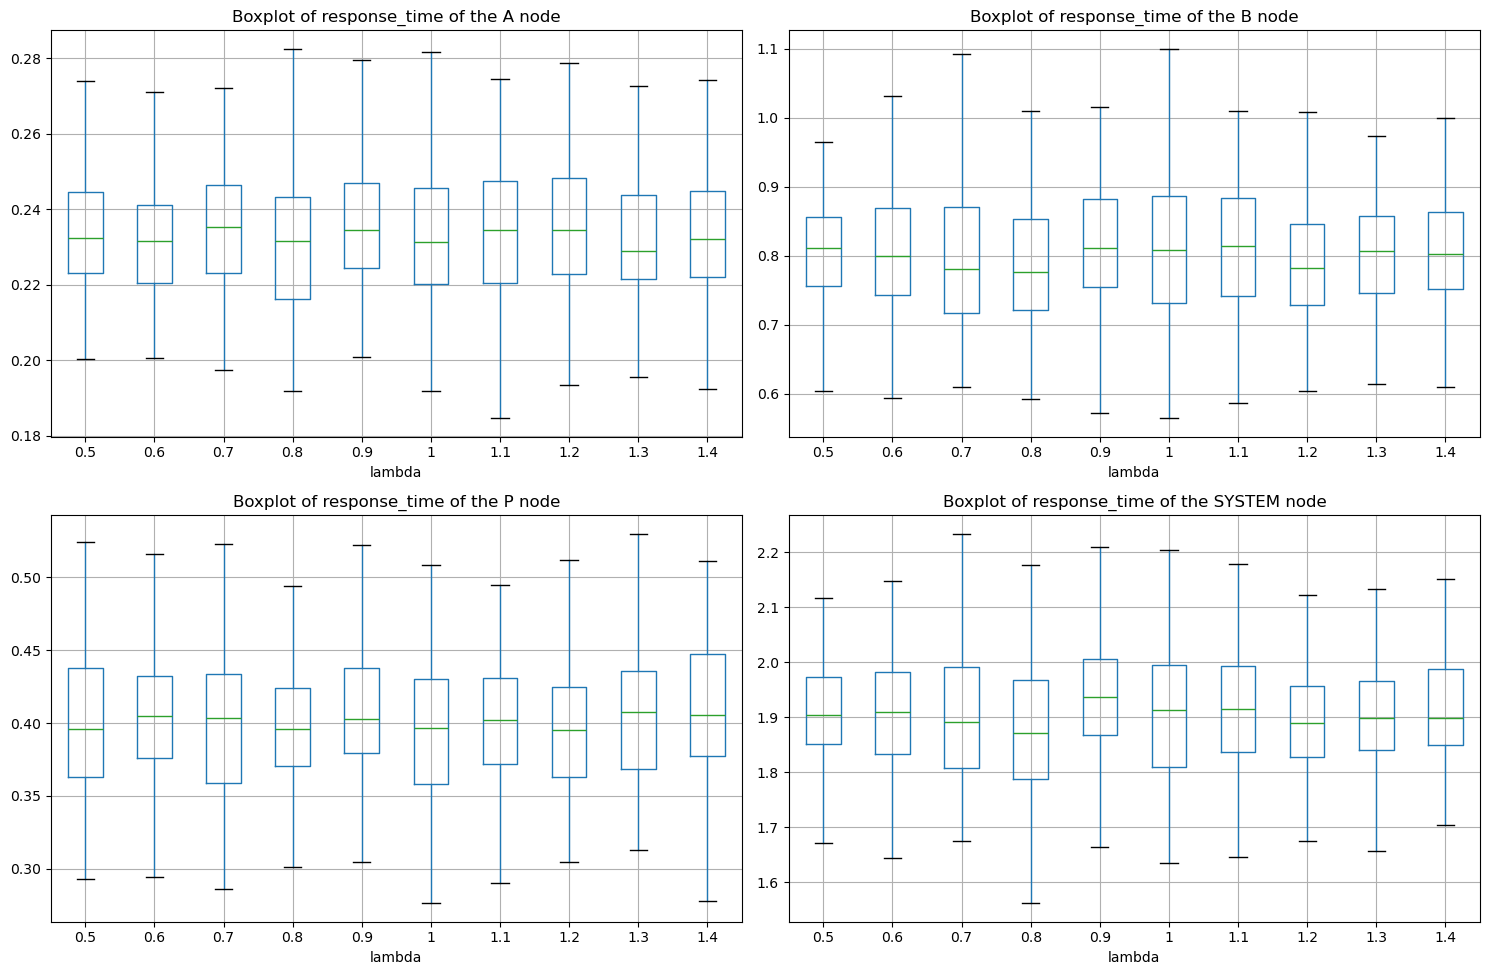

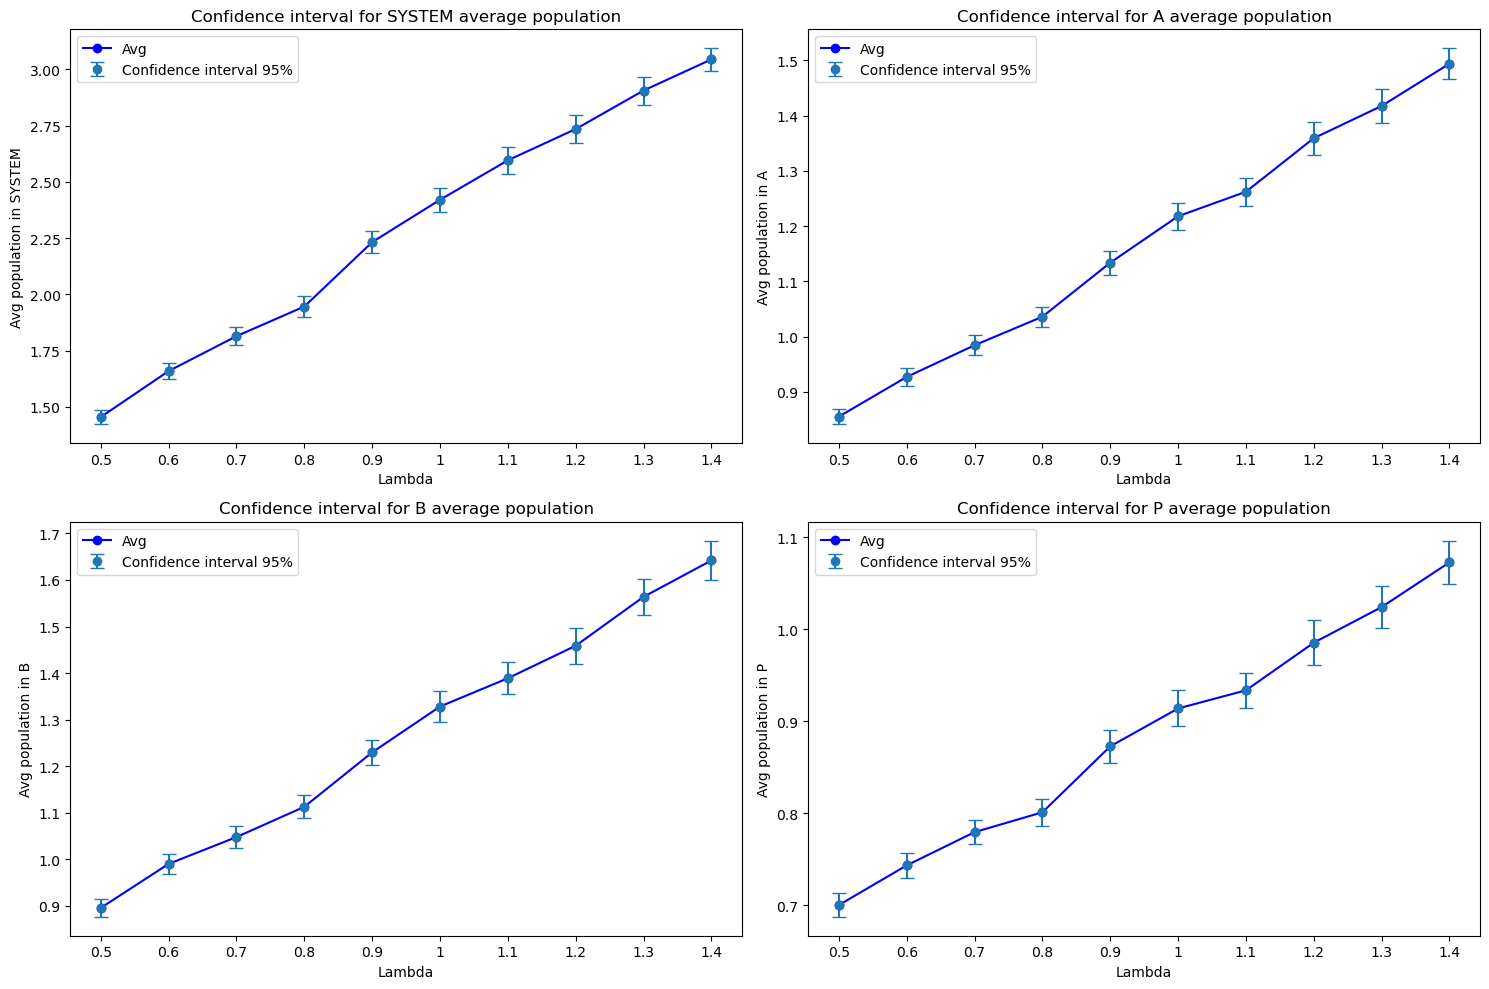

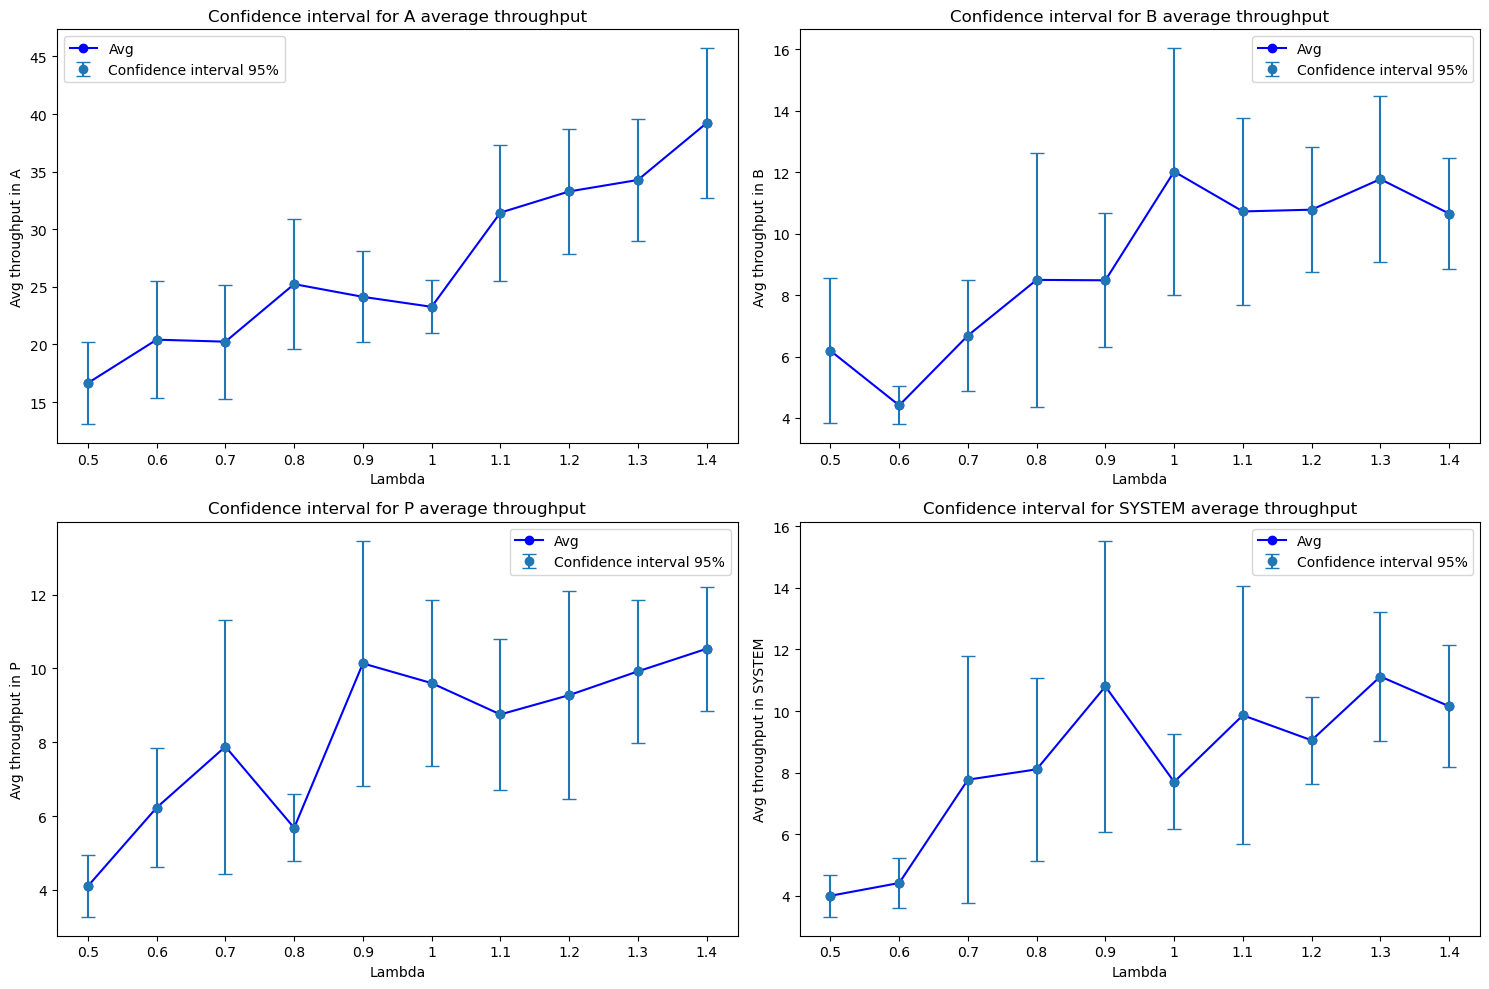

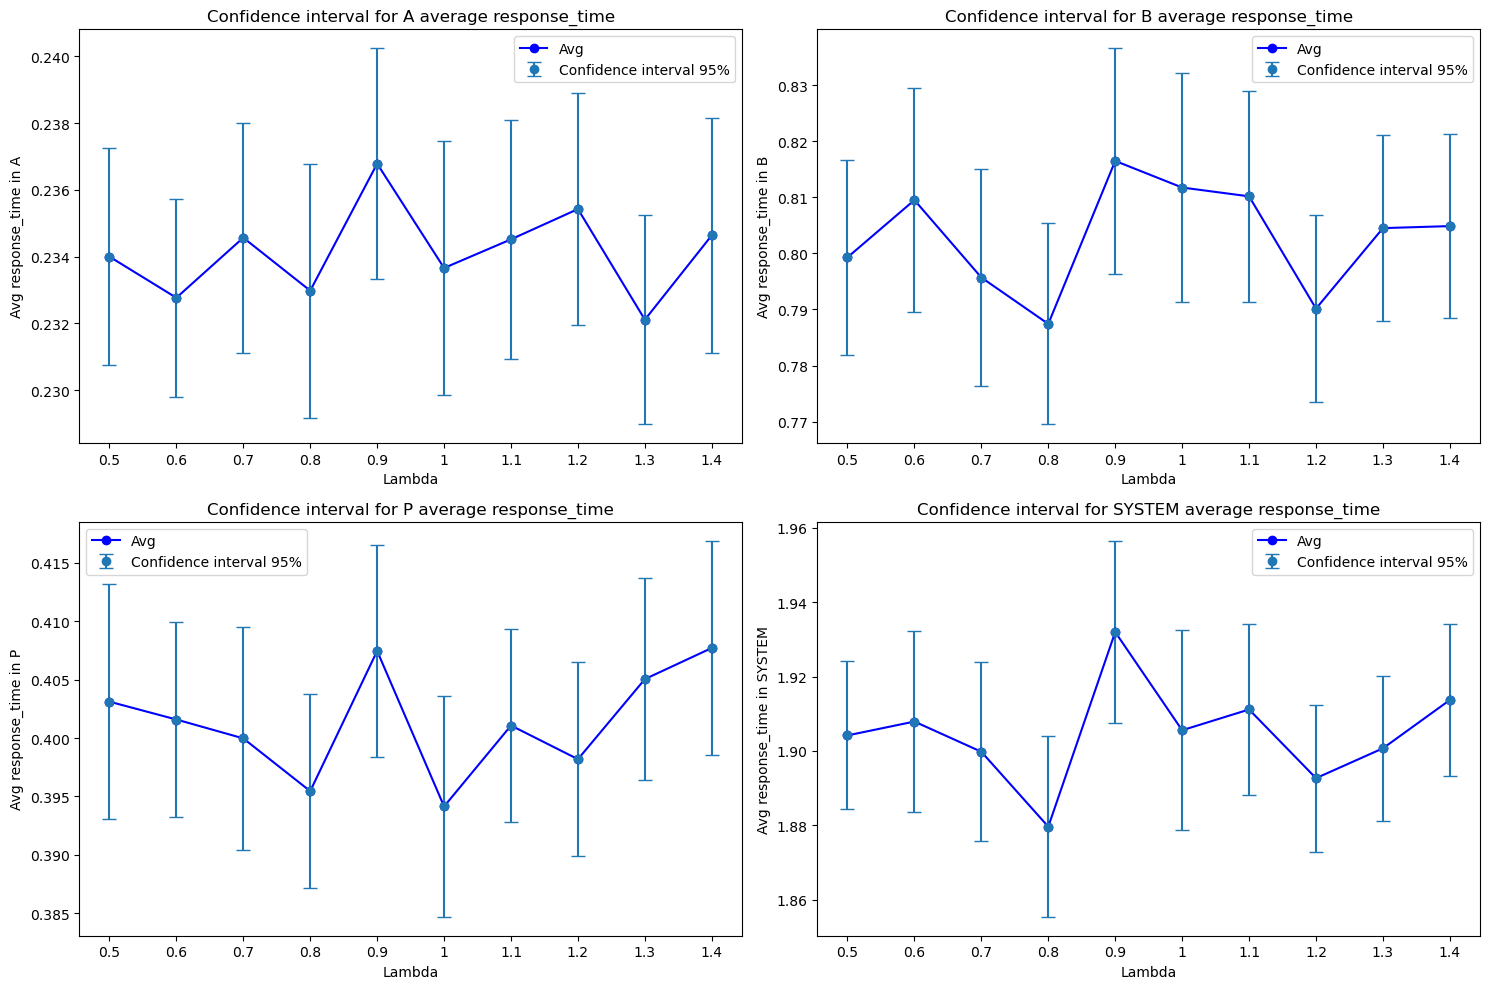

In [14]:
path = os.path.join("..", "..", "src", "caballo", "domestico", "wwsimulator", "statistics", "objective_3")
critical_value = scipy.stats.norm.ppf(1-.05/2)

metrics_nodes_avg_df_list = preprocessing(path)
boxplot(metrics_nodes_avg_df_list)
cv_df = confidence_interval(metrics_nodes_avg_df_list, critical_value)
plot_confidence_interval(cv_df)